In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
# Custom extra width cells
from IPython.core.display import HTML, display
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import auc


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

import censusdata
import reverse_geocode

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Data dir path from root of project
data_dir = "../data"

# Load data
df_wsp = pd.read_csv(f'{data_dir}/fatal-police-shootings-data-wsp.csv')

# Population Data
population_df = pd.read_csv(f'{data_dir}/nst-est2019-alldata.csv')


## Section 2


In [5]:
display(df_wsp.head())
display(df_wsp.describe())

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


,id,age,longitude,latitude
count,5716.000000,5456.000000,5437.000000,5437.000000
mean,3173.216235,37.139113,-97.256366,36.650508
std,1789.492388,13.068117,16.629368,5.367021
min,3.000000,6.000000,-158.137000,19.498000
25%,1624.750000,27.000000,-112.134000,33.477000
50%,3174.500000,35.000000,-94.432000,36.100000
75%,4734.250000,46.000000,-83.066000,39.958000
max,6247.000000,91.000000,-68.014000,71.301000


In [6]:
print('Dataset shape: ', df_wsp.shape)

df_wsp.info()

Dataset shape:  (5716, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5716 entries, 0 to 5715
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5716 non-null   int64  
 1   name                     5499 non-null   object 
 2   date                     5716 non-null   object 
 3   manner_of_death          5716 non-null   object 
 4   armed                    5503 non-null   object 
 5   age                      5456 non-null   float64
 6   gender                   5715 non-null   object 
 7   race                     5109 non-null   object 
 8   city                     5716 non-null   object 
 9   state                    5716 non-null   object 
 10  signs_of_mental_illness  5716 non-null   bool   
 11  threat_level             5716 non-null   object 
 12  flee                     5426 non-null   object 
 13  body_camera              5716 non-null   bool   
 1

### Check full null values on row level and cell level

In [7]:
# Custom function to get nan stats for empty rows
def nan_row_stats(df_missing):
    # Get the rows with all null values
    idx = df_missing.index[df_missing.isnull().all(1)]
    nans = df_missing.iloc[idx]
    if len(nans) > 1:
        print("Dataframe has rows with each column value being empty")
        display(nans)
    else:
        print(f"Dataframe with {len(df_missing)} rows, does not have rows with all empty values")
        
# Custom function to get nan stats for values
def nan_vals_stats(df_missing, show_summary=False, show_rows=False):
    # Get the missing values per each column 
    missing_series = df_missing.isna().sum()

    # Concatunate each column's type so we have a better idea for imputation
    missing_types_df = pd.concat([missing_series.rename('Missing'), df_missing.dtypes.rename('Dtype')], axis=1)
    missing_types_df.sort_values(by=['Missing'], ascending=False, inplace=True)
    display(missing_types_df)
    
    # Get the column names where values are missing
    missing_colnames = missing_types_df[missing_types_df['Missing']>0].index.tolist()
    
    if len(missing_colnames) > 0:
        # Output missing column's stats for imputaiton 
        if show_summary:
            # Get the basic information of our missing columns
            display(df_missing[missing_colnames].describe())

        # Also output missing rows, needed to determine adequate imputation method
        if show_rows:
            null_data_df = df_missing[df_missing.isnull().any(axis=1)]
            display(null_data_df)
        
    return missing_colnames

In [8]:
# Output the nan stats with my custom function
nan_row_stats(df_wsp)
missing_cols = nan_vals_stats(df_wsp, True, True)

Dataframe with 5716 rows, does not have rows with all empty values


,Missing,Dtype
race,607,object
flee,290,object
latitude,279,float64
longitude,279,float64
age,260,float64
name,217,object
armed,213,object
gender,1,object
id,0,int64
threat_level,0,object


,latitude,longitude,age
count,5437.000000,5437.000000,5456.000000
mean,36.650508,-97.256366,37.139113
std,5.367021,16.629368,13.068117
min,19.498000,-158.137000,6.000000
25%,33.477000,-112.134000,27.000000
50%,36.100000,-94.432000,35.000000
75%,39.958000,-83.066000,46.000000
max,71.301000,-68.014000,91.000000


,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
15,29,Loren Simpson,2015-01-08,shot,NaN,28.0,M,W,Huntley,MT,False,undetermined,Not fleeing,False,-108.315,45.859,True
26,49,Marcus Golden,2015-01-14,shot,NaN,24.0,M,B,St. Paul,MN,False,attack,Not fleeing,False,-93.094,44.958,True
27,50,Michael Goebel,2015-01-14,shot,NaN,29.0,M,W,Franklin County,MO,False,attack,Not fleeing,False,-90.794,38.317,True
45,85,Dewayne Carr,2015-01-20,shot,NaN,42.0,M,B,Scottsdale,AZ,False,other,Car,False,-111.909,33.509,True
52,101,Demaris Turner,2015-01-23,shot,NaN,29.0,M,B,Fort Lauderdale,FL,False,other,Not fleeing,False,-80.212,26.150,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5710,6233,NaN,2020-10-18,shot,gun,NaN,M,NaN,Sunrise,FL,True,attack,Not fleeing,False,-80.329,26.134,True
5712,6247,Tutuila Pine Koonwaiyou,2020-10-18,shot,gun,37.0,M,NaN,Tooele,UT,False,other,Not fleeing,False,-112.298,40.531,True
5713,6242,NaN,2020-10-19,shot,gun,43.0,M,NaN,South Milwaukee,WI,False,attack,Not fleeing,False,-87.856,42.899,True
5714,6243,Paul Sulkowski,2020-10-19,shot,knife,46.0,M,NaN,Coram,NY,False,other,NaN,False,-73.010,40.875,True


### Validate which rows' cities can be imputed via coordinates
The Washington Post dataset has a boolean value 'is_exact' which reflects the accuracy of the coordinates. true means that the coordinates are for the location of the shooting (within approximately 100 meters). And they also have some 'city' values which are [not exactly a city but rather a county name](https://github.com/washingtonpost/data-police-shootings).

We're going to need the city names to cross reference city density later on, so we're going to add an extra 'city' column for which we match the lat and long for the nearest city the 'reverse_geocode' can find.

This way we can use this city as a backup when cross refercing the population density for each city.

In [9]:
import reverse_geocode

# Validate the library works
print(reverse_geocode.get((-37.81, 144.96)))

# Check how many lat and long coordinates are not exact
display(df_wsp.is_geocoding_exact.value_counts())



{'country_code': 'AU', 'city': 'Melbourne', 'country': 'Australia'}


True     5708
False       8
Name: is_geocoding_exact, dtype: int64

In [10]:
# Create a copy
# df_wsp_dens = df_wsp.copy()

# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityBasedOnCoordinates(row):
    # Get coordinate values
    lat, long, is_exact = row['latitude'] , row['longitude'], row['is_geocoding_exact']
    
    # Exact and Null check
    if is_exact == False or str(lat) == 'nan' or str(long) == 'nan':
        # Return original city
        return row['city']
    location_info = reverse_geocode.get((lat, long))
    return location_info['city']



# Save the result in a new column
df_wsp['city_extra'] = df_wsp.apply(addCityBasedOnCoordinates, axis=1)

display(df_wsp.head(10))

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_extra
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans
5,11,Kenneth Joe Brown,2015-01-04,shot,gun,18.0,M,W,Guthrie,OK,False,attack,Not fleeing,False,-97.423,35.877,True,Guthrie
6,13,Kenneth Arnold Buck,2015-01-05,shot,gun,22.0,M,H,Chandler,AZ,False,attack,Car,False,-111.841,33.328,True,San Carlos
7,15,Brock Nichols,2015-01-06,shot,gun,35.0,M,W,Assaria,KS,False,attack,Not fleeing,False,-97.564,38.704,True,Salina
8,16,Autumn Steele,2015-01-06,shot,unarmed,34.0,F,W,Burlington,IA,False,other,Not fleeing,True,-91.119,40.809,True,Burlington
9,17,Leslie Sapp III,2015-01-06,shot,toy weapon,47.0,M,B,Knoxville,PA,False,attack,Not fleeing,False,-79.991,40.413,True,Mount Oliver


### Population density by city name
We got the population density estimates from [SimpleMaps](https://simplemaps.com/data/us-cities). They've built this dataset from the ground up using authoritative sources such as the U.S. Geological Survey and U.S. Census Bureau.
We are going to use this data to add a city population density column to each incident.

In [11]:
# Data from https://simplemaps.com/data/us-cities
city_df = pd.read_csv(f'{data_dir}/uscities-simplemaps.csv')
city_df.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36061,New York,40.6943,-73.9249,18713220,10715.0,polygon,False,True,America/New_York,1,11229 11226 11225 11224 11222 11221 11220 1138...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1139,-118.4068,12750807,3276.0,polygon,False,True,America/Los_Angeles,1,90291 90293 90292 91316 91311 90037 90031 9000...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8373,-87.6862,8604203,4574.0,polygon,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7839,-80.2102,6445545,5019.0,polygon,False,True,America/New_York,1,33129 33125 33126 33127 33128 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7936,-96.7662,5743938,1526.0,polygon,False,True,America/Chicago,1,75287 75098 75233 75254 75251 75252 75253 7503...,1840019440


### Adding the incident's city population density 
Now that we have the original city (and sometime county) and backup city names from the coordinates, we can make the cross reference on the city population density dataset. 

In [12]:
# The average city density from each us city, needed for imputation
avg_city_dens = city_df['density'].mean()

# To store the fails for inspection
df_fails = pd.DataFrame(columns=df_wsp.columns)

# Use the offline reverse_geopy lubrary to match cities to the coordinates
# http://jonathansoma.com/lede/foundations/classes/pandas%20columns%20and%20functions/apply-a-function-to-every-row-in-a-pandas-dataframe/
def addCityDensity(row):
    global df_fails
    
    # Grab values to match
    state = row['state']
    city = row['city']
    
    # Match based on STATE and city, because a lot of states have cities with the same name
    df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['state_id'] == state ) & (city_df['city'] == city) ]
    
    # Try backup cities that were matched by coordinates
    if len(df_matches.index) == 0:
        city_xtra = row['city_extra']
        df_matches = city_df.loc[(city_df['state_id'] == state ) & (city_df['city'] == city_xtra) ]

    # Null check if no matched at all...
    if len(df_matches.index) == 0:
        # print(f"Could not match city: '{city}' or '{city_xtra}' so imputing average....")
        df_fails = df_fails.append(row, ignore_index=True)
        return avg_city_dens
    
    # Only happened once for a place in Florida and since the wsp doesn't have county, we impute the avg
    elif len(df_matches.index) > 1:
        # display(df_matches)
        mean_similar_matches = df_matches['density'].mean()
        match_cnt = len(df_matches.index)
        print(f"Multiple matches ({match_cnt}) for -> '{(city)} - {state}' so imputing their average: {round(mean_similar_matches, 2)}")
        return mean_similar_matches

    # Return first match
    return df_matches['density'].iloc[0]


# Save the result in a new column
df_wsp['city_density'] = df_wsp.apply(addCityDensity, axis=1)
amount_total =  len(df_wsp.index)
amount_fail = len(df_fails.index)

# Output basic stats
print(f"\n{amount_fail} from the total of {amount_total} did not match any city name from the original cities and coordinates based cities")
print(f"So we have imputed the overal city density for them of: {round(avg_city_dens, 2)}\n")

# Inspect the new df and the rows which did not match
display(df_wsp.head())
# display(df_fails.head())

Multiple matches (3) for -> 'Midway - FL' so imputing their average: 507.67

218 from the total of 5716 did not match any city name from the original cities and coordinates based cities
So we have imputed the overal city density for them of: 515.61



,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_extra,city_density
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0


### Adding merging avg household income by closest coordinate match

We matches the US postal codes mapped to coordinates with the dat from [geonames](http://download.geonames.org/export/zip/)

Now we can create a new zipcode column by finding the neirest postal_code (zipcode) for the given coordinates from each shooting.
We fist tried to search the neirest location with [apply and Harversine Dinstance](https://medium.com/analytics-vidhya/finding-nearest-pair-of-latitude-and-longitude-match-using-python-ce50d62af546), but this unfortuunatley took too long. This took to long becaus each of the 4k+ indicendents need to 1 row of the 50k+ US postal codes where you also need to compare them to get the closest distance.

So we endid up using geopandas, scripy's cKDTree by first converting the lat and long coordinates from both datasets int geomerty Points inside GeoDataFrames. And then we could use all the build in functionality from these libraries, we got most of the code [from here](https://gis.stackexchange.com/a/301935). We did have to make some changes because we needed it to work with our coordinates.

In [13]:
# Add the year column we can use to match the right df
df_wsp['year'] = pd.DatetimeIndex(df_wsp['date']).year
display(df_wsp['year'].value_counts())

# Read our yearly census data
# Get the income data 
df_inc_2015 = pd.read_csv(f"{data_dir}/census_inc_2015", encoding='utf-8')
df_inc_2016 = pd.read_csv(f"{data_dir}/census_inc_2016", encoding='utf-8')
df_inc_2017 = pd.read_csv(f"{data_dir}/census_inc_2017", encoding='utf-8')
df_inc_2018 = pd.read_csv(f"{data_dir}/census_inc_2018", encoding='utf-8')

# Set into a dict -> Exception for file name to match, since 2019 & 2020 not available yet
inc_dict = {
    2015 : df_inc_2015,
    2016 : df_inc_2016,
    2017 : df_inc_2017,
    2018 : df_inc_2018,
    2019 : df_inc_2018,
    2020 : df_inc_2018,
}

# Validate df
df_inc_2018.head()


2019    999
2015    994
2018    990
2017    986
2016    962
2020    785
Name: year, dtype: int64

,ZCTA5,Avg_household_inc,postal_code,latitude,longitude,acc_lat_long,Place_state,Place,State
0,1001,7481,1001,42.0702,-72.6227,4.0,"Agawam Town city, Massachusetts",Agawam Town city,Massachusetts
1,1002,9877,1002,42.3671,-72.4646,4.0,"North Amherst CDP, Massachusetts",North Amherst CDP,Massachusetts
2,1002,9877,1002,42.3671,-72.4646,4.0,"Amherst Center CDP, Massachusetts",Amherst Center CDP,Massachusetts
3,1002,9877,1002,42.3671,-72.4646,4.0,"South Amherst CDP, Massachusetts",South Amherst CDP,Massachusetts
4,1003,36,1003,42.3919,-72.5248,4.0,"North Amherst CDP, Massachusetts",North Amherst CDP,Massachusetts


In [14]:
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point

# Convert to the right dfs
df_inc_small = df_inc_2018[["Avg_household_inc", "longitude", "latitude"]]

# Temporarely remove rows that don't have lat/long coordinates
df_wsp_no_coordinates = df_wsp.loc[df_wsp['latitude'].isnull()]
df_wsp_geo = df_wsp[pd.notnull(df_wsp['latitude'])]

# Output info
print(f"Full amount: {len(df_wsp.index)} and Amount geo wsp: {len(df_wsp_geo.index)}")


# https://gis.stackexchange.com/questions/222315/geopandas-find-nearest-point-in-other-dataframe 
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), 
         gdB.loc[idx, gdB.columns == 'Avg_household_inc'].reset_index(drop=True),
         pd.Series(dist, name='inc_coor_dist_match')], axis=1)
    
    # Remove the geometry col after usage
    gdf.drop(columns=['geometry'], inplace=True)
    
    return pd.DataFrame(gdf)


def match_avg_inc(year, year_inc_df):
    # Grab all incidents 1 year
    wsp_year_df = df_wsp_geo.loc[df_wsp_geo['year'] == year]
    
    # https://geopandas.org/gallery/create_geopandas_from_pandas.html#from-longitudes-and-latitudes
    gdf_wsp = gpd.GeoDataFrame(
        wsp_year_df, geometry=gpd.points_from_xy(wsp_year_df.longitude, wsp_year_df.latitude))
    inc_wsp = gpd.GeoDataFrame(
        year_inc_df, geometry=gpd.points_from_xy(year_inc_df.longitude, year_inc_df.latitude))

    # Output dfs before the operation
    # display(gdf_wsp.head())
    # display(wsp_year_df.head())

    # display(ckdnearest(gdf_wsp, inc_wsp))
    return ckdnearest(gdf_wsp, inc_wsp)
    
    

Full amount: 5716 and Amount geo wsp: 5437


In [15]:
# To store each year's result
wsp_year_dfs = []

# Match the closest coordinates incomes to the right years
for year, year_inc_df in inc_dict.items():
    print(f"Matching income for year -> {year}")
    df_inc_year = match_avg_inc(year, year_inc_df)
    wsp_year_dfs.append(df_inc_year)
    # display(df_inc_year)
#     break
    
# Concatunate back together and sort back to original order
df_wsp_inc = pd.concat(wsp_year_dfs, axis=0)

# Add back the rows with no coordinates
df_wsp_inc = pd.concat([df_wsp_inc, df_wsp_no_coordinates], axis=0)

# Sort by data and reset the index to be normally indexed
df_wsp_inc.sort_values(by=['date'])
df_wsp_inc.reset_index(inplace=True)

# Validate that we did not loss any rows
print(f"Before amount: {len(df_wsp.index)} & end amount: {len(df_wsp_inc.index)}")
    
# Validate of each ZCTA is matched
display(df_wsp_inc)
nan_vals_stats(df_wsp_inc)

Matching income for year -> 2015
Matching income for year -> 2016
Matching income for year -> 2017
Matching income for year -> 2018
Matching income for year -> 2019
Matching income for year -> 2020
Before amount: 5716 & end amount: 5716


,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_extra,city_density,year,Avg_household_inc,inc_coor_dist_match
0,0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.000000,2015,13426.0,0.038358
1,1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.000000,2015,25043.0,0.045282
2,2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.000000,2015,7310.0,0.007401
3,3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.000000,2015,16456.0,0.011811
4,4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.000000,2015,6141.0,0.006301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5711,5673,6200,NaN,2020-10-01,shot,gun,NaN,M,NaN,Whitby,WV,False,attack,Car,False,NaN,NaN,True,Whitby,515.613848,2020,NaN,NaN
5712,5696,6229,Anthony Jones,2020-10-12,shot and Tasered,gun,24.0,M,NaN,Bethel Springs,TN,False,other,Car,False,NaN,NaN,True,Bethel Springs,125.000000,2020,NaN,NaN
5713,5698,6231,NaN,2020-10-14,shot,gun,NaN,M,NaN,South Los Angeles,CA,False,attack,Not fleeing,False,NaN,NaN,True,South Los Angeles,515.613848,2020,NaN,NaN
5714,5701,6230,Steven Vest,2020-10-14,shot and Tasered,knife,30.0,M,W,Chico,CA,False,attack,Foot,False,NaN,NaN,True,Chico,1191.000000,2020,NaN,NaN


,Missing,Dtype
race,607,object
flee,290,object
inc_coor_dist_match,279,float64
longitude,279,float64
Avg_household_inc,279,float64
latitude,279,float64
age,260,float64
name,217,object
armed,213,object
gender,1,object


['race',
 'flee',
 'inc_coor_dist_match',
 'longitude',
 'Avg_household_inc',
 'latitude',
 'age',
 'name',
 'armed',
 'gender']

### Add urban

In [16]:
# Add population density
# Classification from: https://medium.com/codait/got-zip-code-data-prep-it-for-analytics-7022b47652d9
df_wsp = df_wsp_inc

# Mappping
# 2 = Urban (dens >2900)
# 1 = Suburban (100< dense < 2900)
# 0 = Rural (dens < 100)

def func(x):
    if x > 2900:
        return 'urban'
    elif 100 < x <= 2900:
        return 'suburban'
    elif x <= 100:
        return 'rural'

df_wsp['urban'] = df_wsp['city_density'].apply(func)

df_wsp.head()


,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_extra,city_density,year,Avg_household_inc,inc_coor_dist_match,urban
0,0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,2015,13426.0,0.038358,suburban
1,1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,2015,25043.0,0.045282,urban
2,2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,2015,7310.0,0.007401,suburban
3,3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,2015,16456.0,0.011811,urban
4,4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,2015,6141.0,0.006301,suburban


### Add Party

In [17]:
# which states are blue?
blue_states = {2012: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2013: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2014: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2015: ['CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'HI', 'IL', 'IA', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OH', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'],
               2016: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2017: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2018: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2019: ['CA', 'CO', 'CT', 'DE', 'DC', 'HI', 'IL', 'ME', 'MD', 'MA', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'RI', 'VT', 'VA', 'WA'],
               2020: ['AZ', 'CA', 'CO', 'CT', 'DE', 'DC', 'GA', 'HI', 'IL', 'ME', 'MD', 'MA', 'MI', 'MN', 'NV', 'NH', 'NJ', 'NM', 'NY', 'OR', 'PA', 'RI', 'VT', 'VA', 'WA', 'WI'] 
              }

# process
def f1(x):
    return 1 if x.state in blue_states[x.year] else 0
def f2(x):
    return 1 if x.state in blue_states[x.year] else 0

df_wsp['party'] = df_wsp.apply(f2, axis=1)
df_wsp['party'] = df_wsp.apply(f1, axis=1)

# process further
#party_df[['shootings_black', 'shootings_white', 'shootings_other', 'rate_black', 'rate_white', 'rate_other' ]] = party_df[['shootings_black', 'shootings_white', 'shootings_other', 'rate_black', 'rate_white', 'rate_other']].fillna(0)
    

display(df_wsp.head())

,index,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact,city_extra,city_density,year,Avg_household_inc,inc_coor_dist_match,urban,party
0,0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True,Shelton,708.0,2015,13426.0,0.038358,suburban,1
1,1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True,Aloha,2915.0,2015,25043.0,0.045282,urban,1
2,2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True,Wichita,931.0,2015,7310.0,0.007401,suburban,0
3,3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True,Mission District,7256.0,2015,16456.0,0.011811,urban,1
4,4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True,Evans,804.0,2015,6141.0,0.006301,suburban,1


### Cast value

In [18]:
df2 = df_wsp

# Data type conversions
# df2['name'] = df2['name'].astype('category')
df2['manner_of_death'] = df2['manner_of_death'].astype('category')
df2['armed'] = df2['armed'].astype('str')
df2['gender'] = df2['gender'].astype('str')
df2['race'] = df2['race'].astype('str')
df2['city'] = df2['city'].astype('str')
df2['state'] = df2['state'].astype('str')
df2['threat_level'] = df2['threat_level'].astype('str')
df2['flee'] = df2['flee'].astype('str')
df2['signs_of_mental_illness'] = df2['signs_of_mental_illness'].astype('int')
df2['body_camera'] = df2['body_camera'].astype('str')
df2['is_geocoding_exact'] = df2['is_geocoding_exact'].astype('str')

# check again
display(df2.dtypes)


index                         int64
id                            int64
name                         object
date                         object
manner_of_death            category
armed                        object
age                         float64
gender                       object
race                         object
city                         object
state                        object
signs_of_mental_illness       int64
threat_level                 object
flee                         object
body_camera                  object
longitude                   float64
latitude                    float64
is_geocoding_exact           object
city_extra                   object
city_density                float64
year                          int64
Avg_household_inc           float64
inc_coor_dist_match         float64
urban                        object
party                         int64
dtype: object

In [19]:
df2['race'].value_counts()

W      2595
B      1345
H       947
nan     607
A        94
N        81
O        47
Name: race, dtype: int64

### Create new African-American indicator variable

In [20]:
races_keep = ['B']
df2['is_african_american'] = df2['race'].isin(races_keep).astype(np.int8)
df2['is_african_american'].value_counts()


0    4371
1    1345
Name: is_african_american, dtype: int64

### Drop preditors we don't need

In [21]:
df3 = df2.drop(['date', 'longitude', 'latitude', 'city_extra', 'city',
                'index', 'id', 'state', 'inc_coor_dist_match', 'name', 
                'is_geocoding_exact','year', 'race'], axis=1)

df3.head()

,manner_of_death,armed,age,gender,signs_of_mental_illness,threat_level,flee,body_camera,city_density,Avg_household_inc,urban,party,is_african_american
0,shot,gun,53.0,M,1,attack,Not fleeing,False,708.0,13426.0,suburban,1,0
1,shot,gun,47.0,M,0,attack,Not fleeing,False,2915.0,25043.0,urban,1,0
2,shot and Tasered,unarmed,23.0,M,0,other,Not fleeing,False,931.0,7310.0,suburban,0,0
3,shot,toy weapon,32.0,M,1,attack,Not fleeing,False,7256.0,16456.0,urban,1,0
4,shot,nail gun,39.0,M,0,attack,Not fleeing,False,804.0,6141.0,suburban,1,0


In [22]:
nan_row_stats(df3)
nan_vals_stats(df3)

Dataframe with 5716 rows, does not have rows with all empty values


,Missing,Dtype
Avg_household_inc,279,float64
age,260,float64
manner_of_death,0,category
armed,0,object
gender,0,object
signs_of_mental_illness,0,int64
threat_level,0,object
flee,0,object
body_camera,0,object
city_density,0,float64


['Avg_household_inc', 'age']

In [23]:
# Drop nul values
df4 = df3.dropna()
nan_vals_stats(df4)

,Missing,Dtype
manner_of_death,0,category
armed,0,object
age,0,float64
gender,0,object
signs_of_mental_illness,0,int64
threat_level,0,object
flee,0,object
body_camera,0,object
city_density,0,float64
Avg_household_inc,0,float64


[]

### Encode categorical predictors

In [24]:
# Custom one hot encoding function for non numerical columns/features
def one_hot_encode(df_one_hot, cols, drop_orig = False, force_lc = False, output_stats = True):
    encoded_cols_added = 0
    amount_cols_before = len(df_one_hot.columns)
    
    for col in cols:
        dummies = pd.get_dummies(df_one_hot[col], prefix=col)
        print(f"Predictor '{col}' has {len(dummies.columns)} categories added")
        df_one_hot = pd.concat([df_one_hot, dummies], axis=1)
        encoded_cols_added += len(dummies.columns)
    
    # Drop original columns
    if drop_orig:
        df_one_hot = df_one_hot.drop(cols, axis=1)
    
    # Output changes made
    if output_stats:
        print(f"Dropped original -> {drop_orig}")
        print(f"Added {encoded_cols_added} one hot encoded cols.")
        print(f"Started with {amount_cols_before} to a total of {len(df_one_hot.columns)} columns")
    
    # Lowercase all columns if required
    if force_lc:
        df_one_hot.columns= df_one_hot.columns.str.lower()
    
    return df_one_hot

In [25]:
# Categorical variables to process
cat_vars = ['manner_of_death','armed', 'gender', 
            'threat_level', 'flee', 'body_camera', 'urban']


# Enocde all the data
encoded_df = one_hot_encode(df4, cat_vars, drop_orig = True, force_lc = True)

# Validate data mutation and output the rest
display(encoded_df.head())

Predictor 'manner_of_death' has 2 categories added
Predictor 'armed' has 94 categories added
Predictor 'gender' has 2 categories added
Predictor 'threat_level' has 3 categories added
Predictor 'flee' has 5 categories added
Predictor 'body_camera' has 2 categories added
Predictor 'urban' has 3 categories added
Dropped original -> True
Added 111 one hot encoded cols.
Started with 13 to a total of 117 columns


,age,signs_of_mental_illness,city_density,avg_household_inc,party,is_african_american,manner_of_death_shot,manner_of_death_shot and tasered,armed_airsoft pistol,armed_bb gun,armed_bb gun and vehicle,armed_taser,armed_air conditioner,armed_air pistol,armed_ax,armed_barstool,armed_baseball bat,armed_baseball bat and bottle,armed_baseball bat and fireplace poker,armed_baton,armed_bayonet,armed_bean-bag gun,armed_beer bottle,armed_blunt object,armed_bottle,armed_bow and arrow,armed_box cutter,armed_brick,armed_carjack,armed_chain,armed_chain saw,armed_chainsaw,armed_chair,armed_claimed to be armed,armed_contractor's level,armed_cordless drill,armed_crossbow,armed_crowbar,armed_fireworks,armed_flagpole,armed_flashlight,armed_garden tool,armed_glass shard,armed_grenade,armed_gun,armed_gun and car,armed_gun and knife,armed_gun and machete,armed_gun and sword,armed_gun and vehicle,...,armed_metal stick,armed_motorcycle,armed_nail gun,armed_nan,armed_oar,armed_pellet gun,armed_pen,armed_pepper spray,armed_pick-axe,armed_piece of wood,armed_pipe,armed_pitchfork,armed_pole,armed_pole and knife,armed_rock,armed_samurai sword,armed_scissors,armed_screwdriver,armed_sharp object,armed_shovel,armed_spear,armed_stapler,armed_straight edge razor,armed_sword,armed_tire iron,armed_toy weapon,armed_unarmed,armed_undetermined,armed_unknown weapon,armed_vehicle,armed_vehicle and gun,armed_vehicle and machete,armed_walking stick,armed_wasp spray,armed_wrench,gender_f,gender_m,threat_level_attack,threat_level_other,threat_level_undetermined,flee_car,flee_foot,flee_not fleeing,flee_other,flee_nan,body_camera_false,body_camera_true,urban_rural,urban_suburban,urban_urban
0,53.0,1,708.0,13426.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0
1,47.0,0,2915.0,25043.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1
2,23.0,0,931.0,7310.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0
3,32.0,1,7256.0,16456.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1
4,39.0,0,804.0,6141.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0


### Create model data

In [26]:
# Grab predictors, response and stratify variable
X = encoded_df.drop('signs_of_mental_illness', axis=1)
y = encoded_df[['signs_of_mental_illness']]

# Create series to make sure is_african_american and mental_illness are stratified
# https://stackoverflow.com/a/51525992/8970591
strat_mental_health_aa = encoded_df['signs_of_mental_illness'].astype(str) + \
                         encoded_df['is_african_american'].astype(str)



# Split the data 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    stratify=strat_mental_health_aa,
                                                    random_state=42)


# Lastly output the shapes for validation
print("Shape all data:")
print(encoded_df.shape)

print("\nShape X_train and y_train:")
print(X_train.shape, y_train.shape)

print("\nShape X_test and y_test:")
print(X_test.shape, y_test.shape)

Shape all data:
(5198, 117)

Shape X_train and y_train:
(3638, 116) (3638, 1)

Shape X_test and y_test:
(1560, 116) (1560, 1)


In [27]:
# Re-usable function to output the model's coefficents and intercept
def output_model_coef(model, predictors, reg_type = "Logisitc"):
    # Get the coefficient estimates
    for i in range(len(predictors)):
        if i == 0:
            print(f"{reg_type} Regression est. B0 (Intercept): {model.intercept_[0]:.4f}")

        coef_val = model.coef_.flat[i]
        print(f"{reg_type} Regression est. B{i + 1} ({predictors[i]}): {coef_val:.4f}")

In [28]:
# Values to use
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
penalty = 'l1' # l1 -> L1 -> LASSO
solver = 'liblinear' # -> You will get warning because LASSO can only work with this solver
folds = 3

# Fit a well-tuned Lasso-like logistic regression model from all 12 predictors in it
# The default scoring option used is accuracy_score
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
logit_lasso = LogisticRegressionCV(
    Cs=Cs, cv=folds, penalty=penalty, solver='liblinear'
).fit(X_train, y_train)

# Print out the coefficient estimates
output_model_coef(logit_lasso, X.columns, "Lasso-like Logistic Regression")

# Get the classification scores
logit_lasso_train_score = logit_lasso.score(X_train, y_train) * 100
logit_lasso_test_score = logit_lasso.score(X_test, y_test) * 100

# Add a new line for better readability of the output
print("\n")

# Report the classification accuracy on train and test for this model.
print(f"Training Set Accuracy Lasso-like Logistic Regression full: {logit_lasso_train_score:.4f}%")
print(f"Testing Set Accuracy Lasso-like Logistic Regression full: {logit_lasso_test_score:.4f}%")

Lasso-like Logistic Regression Regression est. B0 (Intercept): -0.8520
Lasso-like Logistic Regression Regression est. B1 (age): 0.0119
Lasso-like Logistic Regression Regression est. B2 (city_density): 0.0000
Lasso-like Logistic Regression Regression est. B3 (avg_household_inc): -0.0000
Lasso-like Logistic Regression Regression est. B4 (party): 0.0000
Lasso-like Logistic Regression Regression est. B5 (is_african_american): -0.4404
Lasso-like Logistic Regression Regression est. B6 (manner_of_death_shot): -0.3230
Lasso-like Logistic Regression Regression est. B7 (manner_of_death_shot and tasered): 0.0000
Lasso-like Logistic Regression Regression est. B8 (armed_airsoft pistol): 0.0000
Lasso-like Logistic Regression Regression est. B9 (armed_bb gun): 0.0000
Lasso-like Logistic Regression Regression est. B10 (armed_bb gun and vehicle): 0.0000
Lasso-like Logistic Regression Regression est. B11 (armed_taser): 0.0000
Lasso-like Logistic Regression Regression est. B12 (armed_air conditioner): 0.

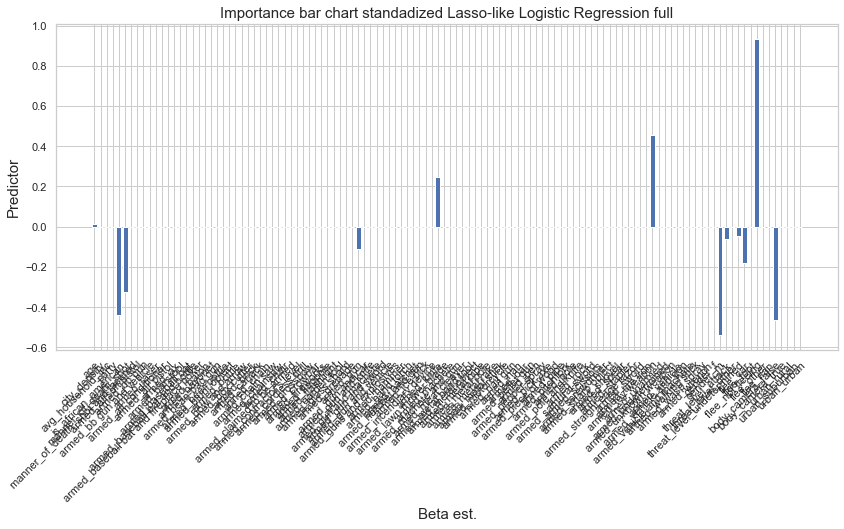

In [29]:
# Custom function to visualize importance predictors
def preds_importance_barchart(lasso_coef, preds):
    # Create a bar chart to visualize importance of our scaled predictors
    fig, ax = plt.subplots(figsize = (14,6),facecolor='w')

    ax.bar(np.arange(lasso_coef.size), lasso_coef)
    ax.set_xticks(np.arange(len(preds)))
    ax.set_xticklabels(preds,  rotation=45, ha="right", rotation_mode="anchor")

    # Add the labelsb
    ax.set_title('Importance bar chart standadized Lasso-like Logistic Regression full',fontsize= 15)
    ax.set_xlabel('Beta est.', fontsize=15)
    ax.set_ylabel('Predictor', fontsize=15)
    

    
# Grab the coefficients
lasso_coef = logit_lasso.coef_[0]
preds_importance_barchart(lasso_coef, X.columns)

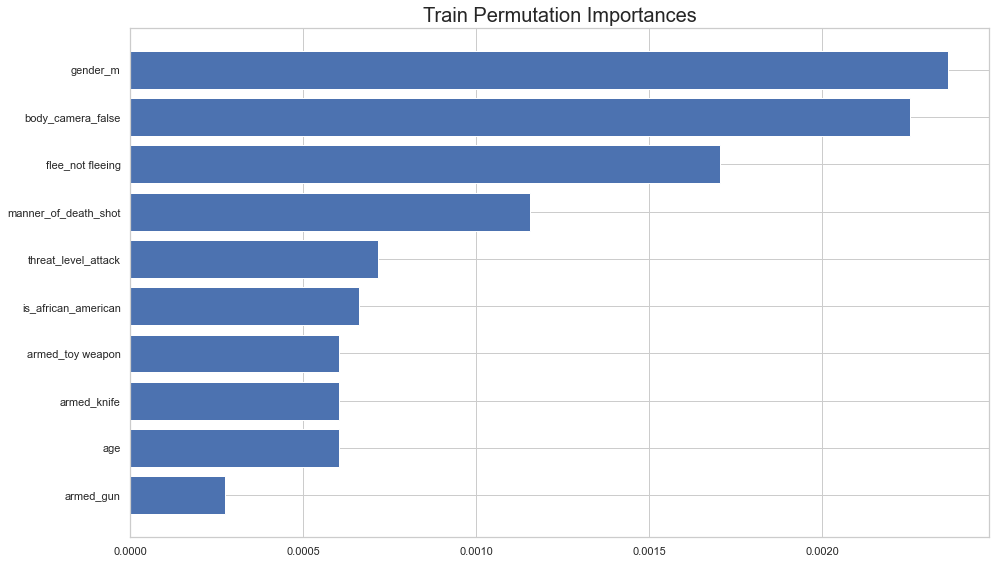

In [30]:
# You can use the default number of n_repeats (5) and your estimator's default scorer
# To speed up the time it takes to run your permutations, you can try setting n_jobs=-1
# to take full advantage of all of your available processor cores.
per_imp_train = permutation_importance(logit_lasso, X_train, y_train, 
                                n_repeats=5, # Default
                                scoring='accuracy',
                                n_jobs=-1, #Takes as many threads as possible
                                random_state=42)

# https://scikit-learn.org/0.22/auto_examples/inspection/plot_permutation_importance.html
len_data = len(per_imp_train.importances_mean) # Needed for negative indexing
sorted_per_imp_index = per_imp_train.importances_mean.argsort()[-10:len_data]

# Get the actual mean permutation importance values and their corresponding feature names
relat_imp_feat_names = X.columns[sorted_per_imp_index]
relat_imp_means = per_imp_train.importances_mean[sorted_per_imp_index].tolist()

# Get the plots ready
fig, ax = plt.subplots(figsize = (14,8))

y_ticks = np.arange(0, len(relat_imp_feat_names))
ax.barh(y_ticks, relat_imp_means)
ax.set_yticklabels(relat_imp_feat_names)
ax.set_yticks(y_ticks)
ax.set_title("Train Permutation Importances", fontsize=20)
fig.tight_layout()
plt.show()


In [31]:
# Get indices per race     
race_indices_c = X_test["is_african_american"] == 1
race_indices_aa = X_test["is_african_american"] == 0

# Reshape
y_train_shape = y_train.values.reshape(-1,)
y_test_shape = y_test.values.reshape(-1,)

# Match true values per race
y_test_race_c = y_test_shape[race_indices_c]
y_test_race_aa = y_test_shape[race_indices_aa]
# print(y_test_race_c)
# print(y_test_race_aa)


def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return (TP, FP, TN, FN)


def get_fp_race_groups(y_true, y_pred):
    # Get the values we need
    TP, FP, TN, FN = perf_measure(y_true, y_pred)
    
    # FPR -> False postive rate
    # It’s the probability that a false alarm will be raised
    # that a positive result will be given when the true value is negative.
    FPR = FP/(FP+TN)
    
    # FNR -> False negative rate -> Miss rate
    # The probability that a true positive will be missed by the test.
    FNR = FN/(FN+TP)
    
    return FPR, FNR


# https://stackoverflow.com/a/53124075/8970591
def percentage(part,whole):
    if whole == 0:
        if part == 0:
            return float("nan")
        return float("inf")
    return float(part) / float(whole)



def output_error_scores(logit, X_test_logit, logit_name=""):
    # Get the predictions
    y_test_preds = logit.predict(X_test_logit)

    # Match race based predictions
    y_pred_race_c = y_test_preds[race_indices_c]
    y_pred_race_aa = y_test_preds[race_indices_aa]

    # 2) False Positive Rate(FPR) as a percentage for the groups (*note a positive here is two_year_recid==1)
    # 3) False Negative Rate(FNR) as a percentage for the groups
    # Get both rates
    FPR_race_c, FNR_race_c = get_fp_race_groups(y_test_race_c, y_pred_race_c)
    FPR_race_aa, FNR_race_aa = get_fp_race_groups(y_test_race_aa, y_pred_race_aa)

    # Output FPR & FNR results
    print(f"Log. Regress ({logit_name}) -> False Positive Rate(FPR) Non African-American: \t{FPR_race_c}")
    print(f"Log. Regress ({logit_name}) -> False Negative Rate(FNR) Non African-American: \t{FNR_race_c} \n")
    print(f"Log. Regress ({logit_name}) -> False Positive Rate(FPR) African-American: \t{FPR_race_aa}")
    print(f"Log. Regress ({logit_name}) -> False Negative Rate(FNR) African-American: \t{FNR_race_aa} \n")

    # 4) Ratios of Error Rates:
    ratio_err_rate_FPR = percentage(FPR_race_aa,  FPR_race_c)
    ratio_err_rate_FNR = percentage(FNR_race_aa, FNR_race_c)

    # Ouput the restults
    print(f"Log. Regress ({logit_name}) -> Ratio of the FPR between African-American and Non African-American groups: \t{ratio_err_rate_FPR}")
    print(f"Log. Regress ({logit_name}) -> Ratio of the FNR between African-American and Non African-American groups: \t{ratio_err_rate_FNR}")

In [32]:


# Report all the scores
output_error_scores(logit_lasso, X_test, logit_name="LASSO Mental health")

Log. Regress (LASSO Mental health) -> False Positive Rate(FPR) Non African-American: 	0.0
Log. Regress (LASSO Mental health) -> False Negative Rate(FNR) Non African-American: 	0.9833333333333333 

Log. Regress (LASSO Mental health) -> False Positive Rate(FPR) African-American: 	0.008045977011494253
Log. Regress (LASSO Mental health) -> False Negative Rate(FNR) African-American: 	0.9644012944983819 

Log. Regress (LASSO Mental health) -> Ratio of the FPR between African-American and Non African-American groups: 	inf
Log. Regress (LASSO Mental health) -> Ratio of the FNR between African-American and Non African-American groups: 	0.9807470791508969


### Race based ROC

Log. Regress (no race) -> AUC for Causcasian:       	0.6856697819314642
Log. Regress (no race) -> AUC for African-American: 	0.6648737120113083


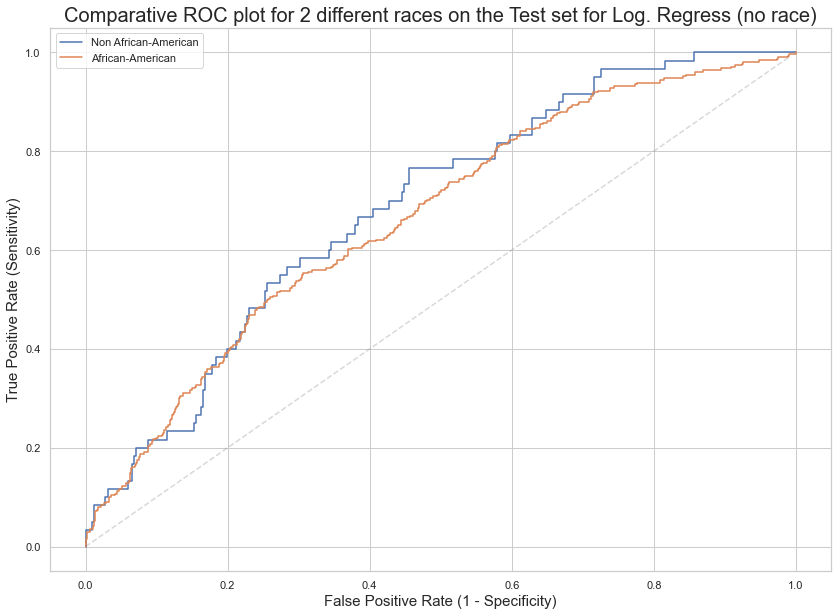

In [33]:
# Get the predicted probabilities
y_pred_proba = logit_lasso.predict_proba(X_test)
y_pred_proba_race_c = y_pred_proba[race_indices_c][:,1]
y_pred_proba_race_aa = y_pred_proba[race_indices_aa][:,1]

# Create a bar chart to visualize importance of our scaled predictors
fig, ax = plt.subplots(figsize = (14,10),facecolor='w')

# Get ROC curve metrics
fpr_c, tpr_c, thresholds_c = roc_curve(y_test_race_c, y_pred_proba_race_c)
fpr_aa, tpr_aa, thresholds_aa = roc_curve(y_test_race_aa, y_pred_proba_race_aa)

# Add ROC lines to the plot
ax.plot(fpr_c, tpr_c, label='Non African-American')
ax.plot(fpr_aa, tpr_aa, label='African-American')

# Log the model's AUC for both races
print(F"Log. Regress (no race) -> AUC for Causcasian:       \t{auc(fpr_c, tpr_c)}")
print(F"Log. Regress (no race) -> AUC for African-American: \t{auc(fpr_aa, tpr_aa)}")

# Add coin flip indicator, so 50/50
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)

# Add the labels and show the graph
ax.set_ylabel("True Positive Rate (Sensitivity)",fontsize= 15)
ax.set_xlabel("False Positive Rate (1 - Specificity)",fontsize= 15)
ax.set_title("Comparative ROC plot for 2 different races on the Test set for Log. Regress (no race)",fontsize= 20)
ax.legend()
plt.show()